## Demo for the Correlated Field Model

The correlated field model (cfm) aims to model reasonable prior assumptions on physical situations. Fields are assumed to be smooth, homogenous, and isotropic which implies that a harmonic power spectrum can model statistical correlations in the resulting field.

The cfm (in its current form) is a Gaussian process model whose excitations are standard Gaussians and whose power spectrum is also modelled as a Gaussian process. In this way, both, the correlation structure and the particular realisation of the Gaussian process that best matches data, can be learned by the cfm.

In [1]:
# required packages
import nifty8.re as jft
import jax
from jax import random, numpy as jnp

import matplotlib.pyplot as plt

#### Hyperparameters
The zero mode settings set the overall level of the field and the fluctuations model the shape of the power spectrum.

Feeding in tuples as parameters triggers the cfm to assume that the values are the mean and variance for a lognormal prior (flucutations, flexibility, asperity, offset_std) or normal prior (loglogslope). One can also feed in a model as parameters.

In [2]:
cfm_zero_mode = dict(offset_mean=-3,
                     offset_std=(2.0, 1.0))

cfm_fluctuations = dict(fluctuations=(1.0, 0.5),
                        loglogavgslope=(-3.0, 1.5),
                        flexibility=(2.0, 1.0),
                        asperity=(2.0, 1.0))

The hyperparameters model the power spectrum. The output field is obtained by taking a standard normal distribution for the power spectrum ($\xi$), colouring it with the modelled power (actually amplitude) spectrum ($\mathcal{A}$), and then Fourier transforming ($\mathcal{F}$) to the non-harmonic domain:
$$
 \text{field} = \mathcal{F} \mathcal{A} \, \xi.
$$

Having specified the correlation structure, we now need to specify the shape of the output field to finish the cfm.

In [3]:
# space info
dims = (256,)
distances = 1.0/dims[0]

# create the cfm
cfm = jft.CorrelatedFieldMaker('test')
cfm.add_fluctuations(dims,
                     distances=distances,
                     **cfm_fluctuations,
                     prefix="",
                     non_parametric_kind="power")
cfm.set_amplitude_total_offset(**cfm_zero_mode)

ps_cfm = cfm.power_spectrum
correlated_field = cfm.finalize()

Let's visualise!

As we need some stochasticity to model the probablistic model, we need some random numbers. random from jax.numpy is used to supply us with random numbers.

In [4]:
# create a seed
seed = 934857243958
key = random.PRNGKey(seed)

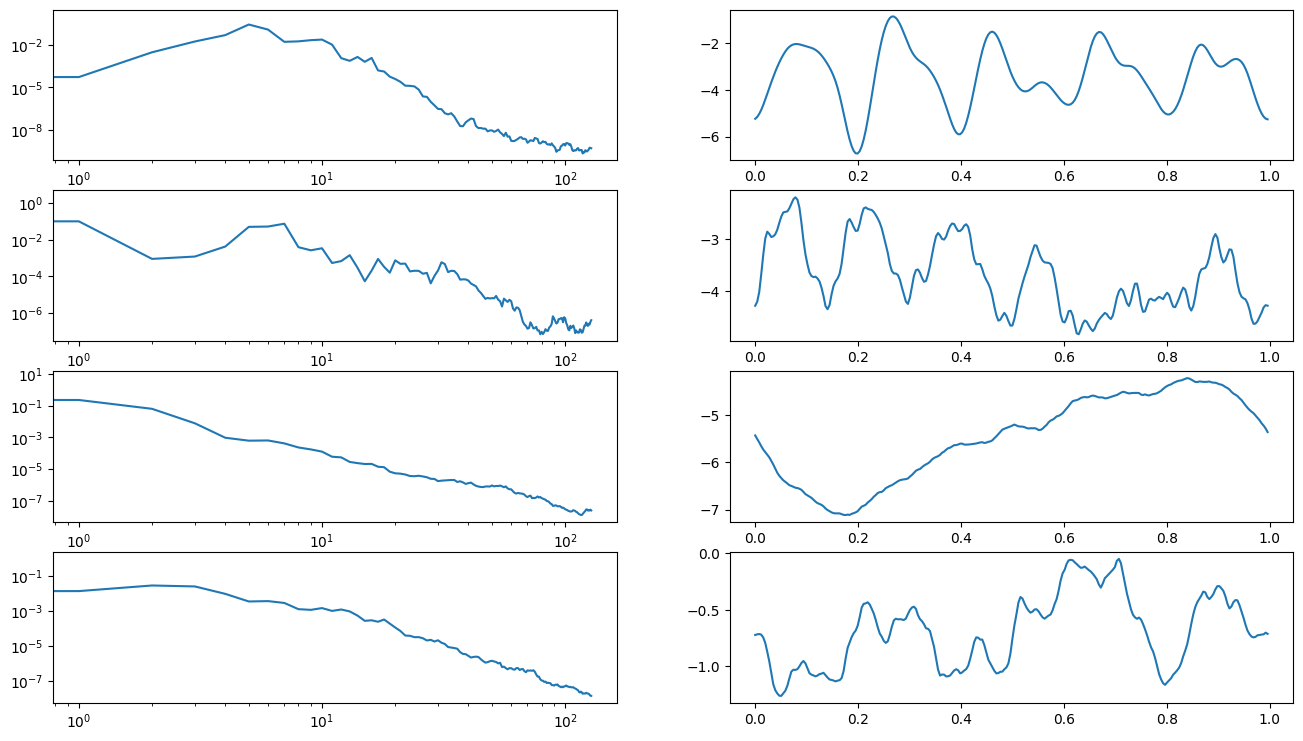

In [5]:
xs = jnp.arange(dims[0])*distances
nus = correlated_field.target_grids[0].harmonic_grid.mode_lengths

yss = []
pss = []

for i in range(4):
    # create a random key
    key, subkey = random.split(key)
    
    # use it to draw a random sample
    rand_pos = jft.random_like(subkey, correlated_field.domain)
    
    # and plot!
    yss.append(correlated_field(rand_pos))
    pss.append(ps_cfm(rand_pos))

fig, axs = plt.subplots(4,2, figsize=(16,9))

for i in range(4):
    axs[i,0].loglog(nus, pss[i])
    axs[i,1].plot(xs,yss[i])

plt.show()

#### (Hyper)parameter showcase

We create a default set of hyperparameters in order to highlight the functions of the different parameters.

In [6]:
showcase_cfm_zero_mode = dict(offset_mean=0,
                              offset_std=lambda x: 1e-9)

showcase_cfm_fluctuations = dict(fluctuations=lambda x: 1e-9,
                                 loglogavgslope=lambda x: 0,
                                 flexibility=lambda x: 1e-9,
                                 asperity=lambda x: 1e-9)
dims = (256,)
distances = 1/dims[0]

We now vary each parameter one by one and see how they affect the power spectrum and realisations.

Let us first see what variations in offset mean achieve.

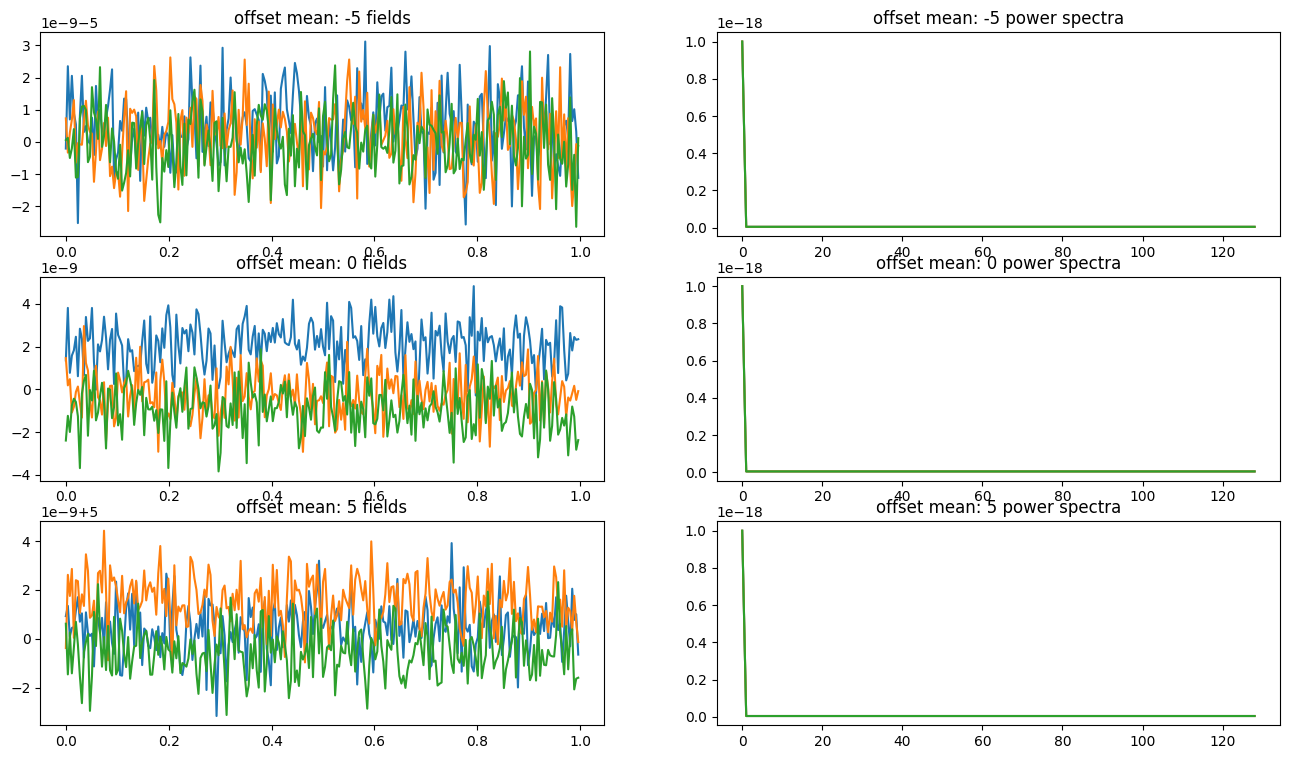

In [7]:
fig, axs = plt.subplots(3,2, figsize=(16,9))

for i, offset_mean in enumerate([-5,0,5]):
    showcase_cfm_zero_mode['offset_mean'] = offset_mean
    
    # create the cfm
    showcase_cfm = jft.CorrelatedFieldMaker('showcase')
    showcase_cfm.add_fluctuations(dims,
                         distances=distances,
                         **showcase_cfm_fluctuations,
                         prefix="",
                         non_parametric_kind="power")
    showcase_cfm.set_amplitude_total_offset(**showcase_cfm_zero_mode)
    
    showcase_cfm_ps = showcase_cfm.power_spectrum
    showcase_correlated_field = showcase_cfm.finalize()

    for j in range(3):
        key, subkey = random.split(key)
        rand_pos = jft.random_like(subkey, showcase_correlated_field.domain)
        axs[i,0].plot(xs, showcase_correlated_field(rand_pos))
        axs[i,1].plot(nus, showcase_cfm_ps(rand_pos))
        axs[i,0].title.set_text(f'offset mean: {offset_mean} fields')
        axs[i,1].title.set_text(f'offset mean: {offset_mean} power spectra')
    
plt.show()

We now vary the offset standard deviation.

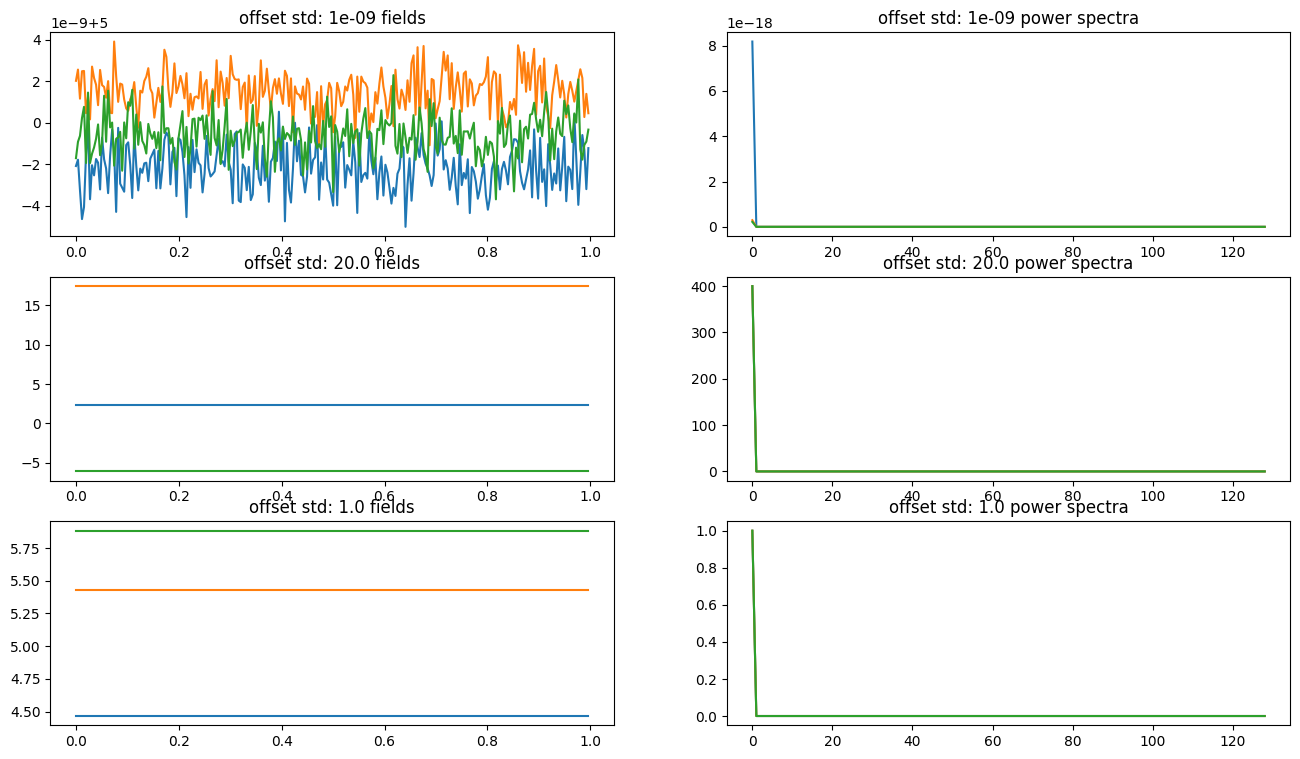

In [8]:
fig, axs = plt.subplots(3,2, figsize=(16,9))

for i, offset_std in enumerate([(1e-9,1e-9), (20.0,1e-9), (1.0,1e-9)]):
    showcase_cfm_zero_mode['offset_std'] = offset_std
    
    # create the cfm
    showcase_cfm = jft.CorrelatedFieldMaker('showcase')
    showcase_cfm.add_fluctuations(dims,
                         distances=distances,
                         **showcase_cfm_fluctuations,
                         prefix="",
                         non_parametric_kind="power")
    showcase_cfm.set_amplitude_total_offset(**showcase_cfm_zero_mode)
    
    showcase_cfm_ps = showcase_cfm.power_spectrum
    showcase_correlated_field = showcase_cfm.finalize()

    for j in range(3):
        key, subkey = random.split(key)
        rand_pos = jft.random_like(subkey, showcase_correlated_field.domain)
        axs[i,0].plot(xs, showcase_correlated_field(rand_pos))
        axs[i,1].plot(nus, showcase_cfm_ps(rand_pos))
        axs[i,0].title.set_text(f'offset std: {offset_std[0]} fields')
        axs[i,1].title.set_text(f'offset std: {offset_std[0]} power spectra')
    
plt.show()

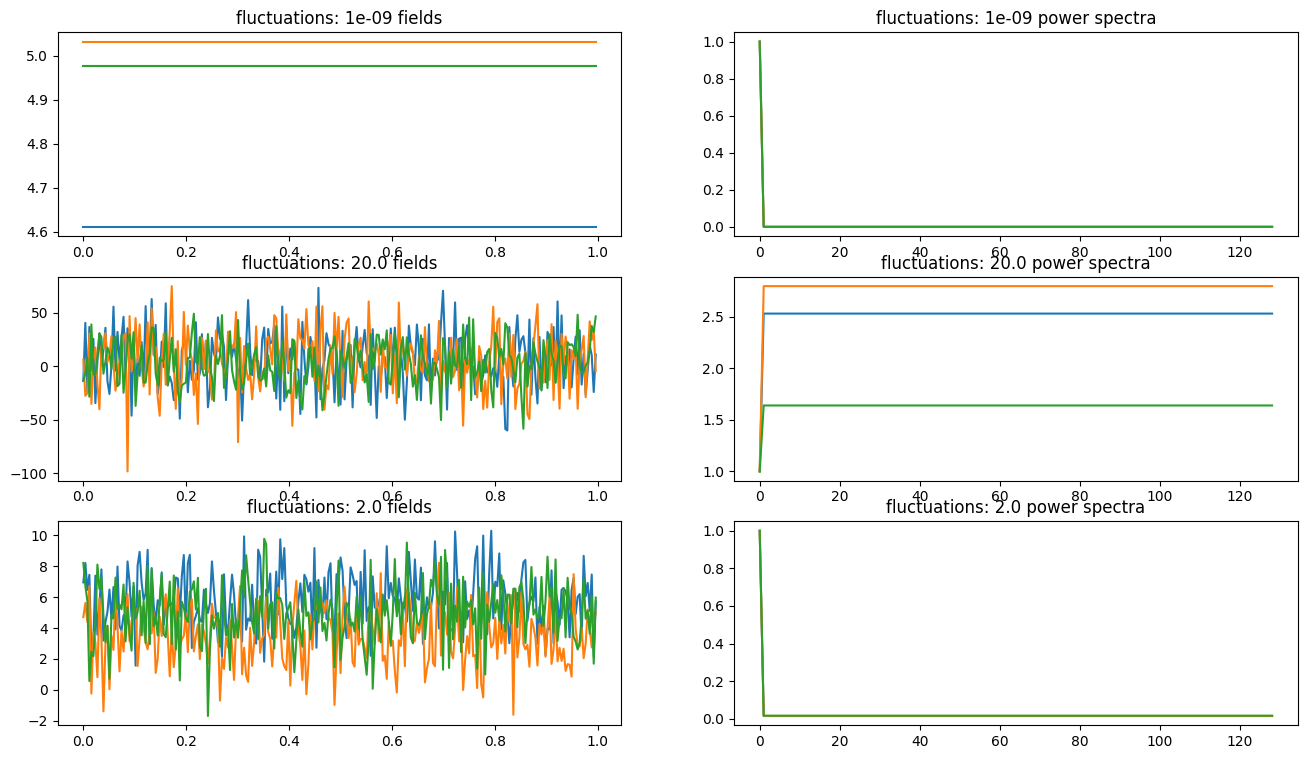

In [9]:
fig, axs = plt.subplots(3,2, figsize=(16,9))

for i, fluctuations in enumerate([(1e-9,1e-9), (20.0,5.0), (2.0,0.1)]):
    showcase_cfm_fluctuations['fluctuations'] = fluctuations
    
    # create the cfm
    showcase_cfm = jft.CorrelatedFieldMaker('showcase')
    showcase_cfm.add_fluctuations(dims,
                         distances=distances,
                         **showcase_cfm_fluctuations,
                         prefix="",
                         non_parametric_kind="power")
    showcase_cfm.set_amplitude_total_offset(**showcase_cfm_zero_mode)
    
    showcase_cfm_ps = showcase_cfm.power_spectrum
    showcase_correlated_field = showcase_cfm.finalize()

    for j in range(3):
        key, subkey = random.split(key)
        rand_pos = jft.random_like(subkey, showcase_correlated_field.domain)
        axs[i,0].plot(xs, showcase_correlated_field(rand_pos))
        axs[i,1].plot(nus, showcase_cfm_ps(rand_pos))
        axs[i,0].title.set_text(f'fluctuations: {fluctuations[0]} fields')
        axs[i,1].title.set_text(f'fluctuations: {fluctuations[0]} power spectra')
    
plt.show()

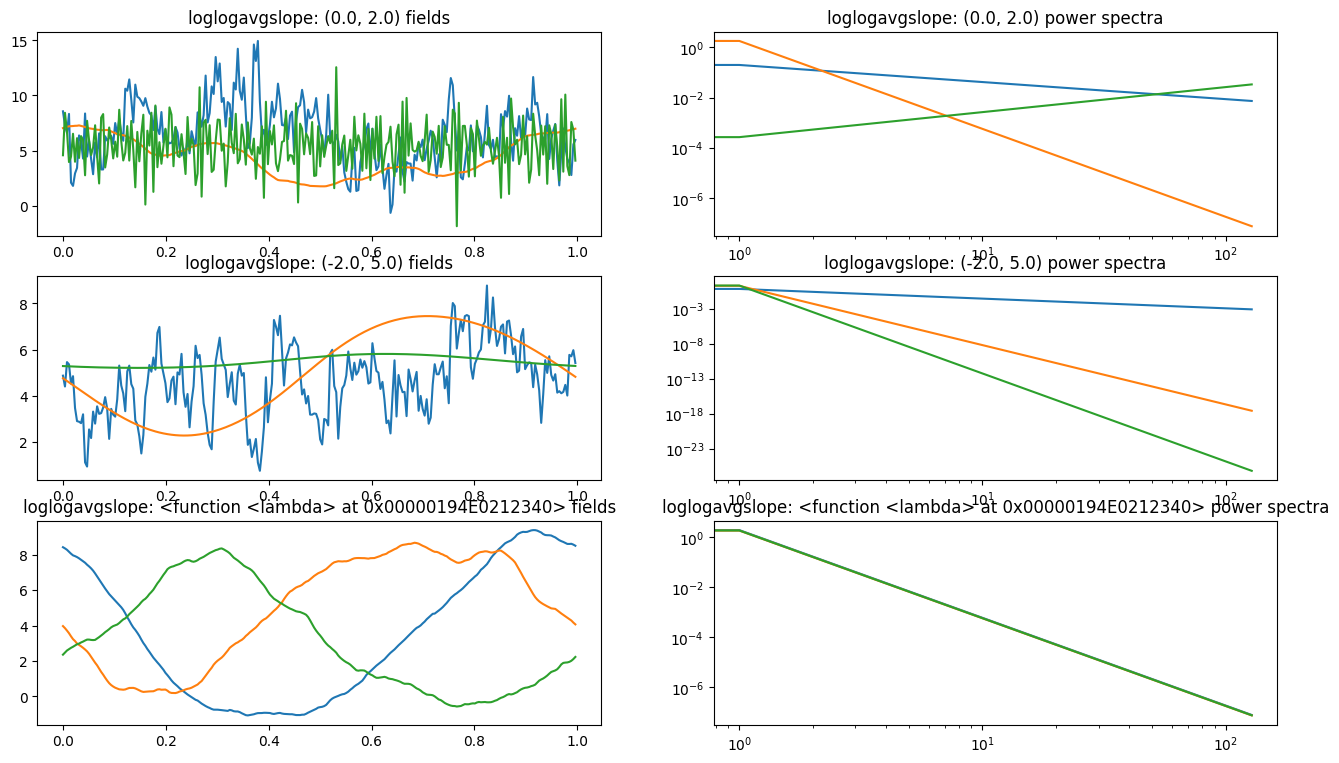

In [10]:
fig, axs = plt.subplots(3,2, figsize=(16,9))

for i, parameter in enumerate([(0.0,2.0), (-2.0,5.0), lambda x: -3.5]):
    showcase_cfm_fluctuations['loglogavgslope'] = parameter
    
    # create the cfm
    showcase_cfm = jft.CorrelatedFieldMaker('showcase')
    showcase_cfm.add_fluctuations(dims,
                         distances=distances,
                         **showcase_cfm_fluctuations,
                         prefix="",
                         non_parametric_kind="power")
    showcase_cfm.set_amplitude_total_offset(**showcase_cfm_zero_mode)
    
    showcase_cfm_ps = showcase_cfm.power_spectrum
    showcase_correlated_field = showcase_cfm.finalize()

    for j in range(3):
        key, subkey = random.split(key)
        rand_pos = jft.random_like(subkey, showcase_correlated_field.domain)
        axs[i,0].plot(xs, showcase_correlated_field(rand_pos))
        axs[i,1].loglog(nus, showcase_cfm_ps(rand_pos))
        axs[i,0].title.set_text(f'loglogavgslope: {parameter} fields')
        axs[i,1].title.set_text(f'loglogavgslope: {parameter} power spectra')
    
plt.show()

#### A reconstruction example
We now try to create some synthetic data and reconstruct the field. Let us use a 2d example for variety.

Let us fix the parameters of the cfm using functions. The Gaussian excitations are still random.

We use the same parameters as the previous cfm but only vary the space dimensions.

In [11]:
# space info
dims = (128,128)
distances = 1.0/dims[0]

We also use a fixed parameter version of the field in order to create the ground truth. We highlight how to pass fixed arguments to the cfm. We can also pass models as parameters; this allows us to create hyperer parameters.

In [12]:
fixed_cfm_zero_mode = dict(offset_mean=-3,
                           offset_std=lambda x: 2.5)

fixed_cfm_fluctuations = dict(fluctuations=lambda x: 2.0,
                              loglogavgslope=lambda x: -4.0,
                              flexibility=lambda x: 1.5,
                              asperity=lambda x: 1.5)

# create the cfm
fcfm = jft.CorrelatedFieldMaker('fixed_params')
fcfm.add_fluctuations(dims,
                     distances=distances,
                     **fixed_cfm_fluctuations,
                     prefix="",
                     non_parametric_kind="power")
fcfm.set_amplitude_total_offset(**cfm_zero_mode)

fixed_ps = fcfm.power_spectrum
fixed_correlated_field = fcfm.finalize()

We now generate a ground truth using the fixed cfm.

In [13]:
key, subkey = random.split(key)
rand_pos = jft.random_like(subkey, fixed_correlated_field.domain)

ground_truth = fixed_correlated_field(rand_pos)
fixed_pow_spec = fixed_ps(rand_pos)

We add Gaussian noise to the ground truth to obtain something to reconstruct.

In [14]:
noise_cov = 1.0
noise_cov_inv = lambda x: noise_cov**-1 * x

key, subkey = random.split(key)
noisy_data = ground_truth + noise_cov*random.normal(subkey, dims)

Let's plot the ground truth and noisy data.

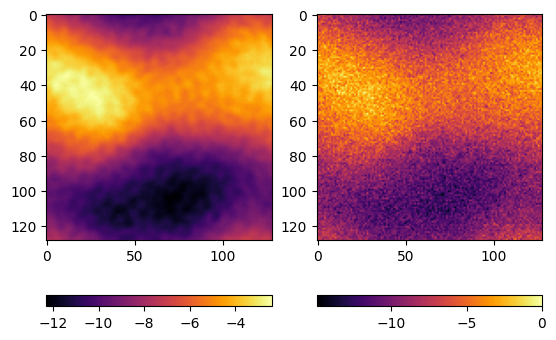

In [15]:
fig, axs = plt.subplots(1,2)

im = axs[0].imshow(ground_truth, cmap="inferno")
plt.colorbar(im, ax=axs[0], orientation="horizontal")

im = axs[1].imshow(noisy_data, cmap="inferno")
plt.colorbar(im, ax=axs[1], orientation="horizontal")

Recreate the cfm from before with new shape.

In [16]:
# recreate the cfm
cfm = jft.CorrelatedFieldMaker('test')
cfm.add_fluctuations(dims,
                     distances=distances,
                     **cfm_fluctuations,
                     prefix="",
                     non_parametric_kind="power")
cfm.set_amplitude_total_offset(**cfm_zero_mode)

cfm_ps = cfm.power_spectrum
correlated_field = cfm.finalize()

In order to perform the reconstruction we need to inform nifty of the noise level and the data. We do that by defining a Gaussian likelihood.

In [17]:
likelihood = jft.Gaussian(noisy_data, noise_cov_inv=noise_cov_inv).amend(correlated_field)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


We now perform the reconstruction.

In [18]:
n_vi_iterations = 10
delta = 1e-4
n_samples = 4

key, k_i, k_o = random.split(key, 3)
# NOTE, changing the number of samples always triggers a resampling even if
# `resamples=False`, as more samples have to be drawn that did not exist before.
samples, state = jft.optimize_kl(
    likelihood,
    jft.Vector(likelihood.init(k_i)),
    n_total_iterations=n_vi_iterations,
    n_samples=lambda i: n_samples // 2 if i < 6 else n_samples,
    # Source for the stochasticity for sampling
    key=k_o,
    # Names of parameters that should not be sampled but still optimized
    # can be specified as point_estimates (effectively we are doing MAP for
    # these degrees of freedom).
    # point_estimates=("cfax1flexibility", "cfax1asperity"),
    # Arguments for the conjugate gradient method used to drawing samples from
    # an implicit covariance matrix
    draw_linear_kwargs=dict(
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(likelihood.domain) / 10.0, maxiter=100),
    ),
    # Arguements for the minimizer in the nonlinear updating of the samples
    nonlinearly_update_kwargs=dict(
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    # Arguments for the minimizer of the KL-divergence cost potential
    kl_kwargs=dict(
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=35
        )
    ),
    sample_mode="nonlinear_resample",
    odir="results_intro",
    resume=False,
)

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+1.3388e+04 Δ⛰:inf ➽:1.9627e-01
SL: Iteration 1 ⛰:-1.0633e+03 Δ⛰:1.4451e+04 ➽:1.9627e-01
SL: Iteration 2 ⛰:-4.5154e+03 Δ⛰:3.4521e+03 ➽:1.9627e-01
SL: Iteration 3 ⛰:-5.2581e+03 Δ⛰:7.4272e+02 ➽:1.9627e-01
SL: Iteration 4 ⛰:-5.6334e+03 Δ⛰:3.7524e+02 ➽:1.9627e-01
SL: Iteration 5 ⛰:-5.9571e+03 Δ⛰:3.2371e+02 ➽:1.9627e-01
SL: Iteration 6 ⛰:-6.3121e+03 Δ⛰:3.5504e+02 ➽:1.9627e-01
SL: Iteration 7 ⛰:-6.6048e+03 Δ⛰:2.9267e+02 ➽:1.9627e-01
SL: Iteration 8 ⛰:-7.2674e+03 Δ⛰:6.6265e+02 ➽:1.9627e-01
SL: Iteration 9 ⛰:-7.2775e+03 Δ⛰:1.0018e+01 ➽:1.9627e-01
SL: Iteration 10 ⛰:-7.5185e+03 Δ⛰:2.4107e+02 ➽:1.9627e-01
SL: Iteration 11 ⛰:-7.6968e+03 Δ⛰:1.7829e+02 ➽:1.9627e-01
SL: Iteration 12 ⛰:-7.7866e+03 Δ⛰:8.9783e+01 ➽:1.9627e-01
SL: Iteration 13 ⛰:-8.0892e+03 Δ⛰:3.0259e+02 ➽:1.9627e-01
SL: Iteration 14 ⛰:-8.3737e+03 Δ⛰:2.8449e+02 ➽:1.9627e-01
SL: Iteration 15 ⛰:-8.7040e+03 Δ⛰:3.3026e+02 ➽:1.9627e-01
SL: Iteration 16 ⛰:-9.0046e+03 Δ⛰:3.0061e+02 ➽:1.9627e-01
SL: 

Let's plot our results.

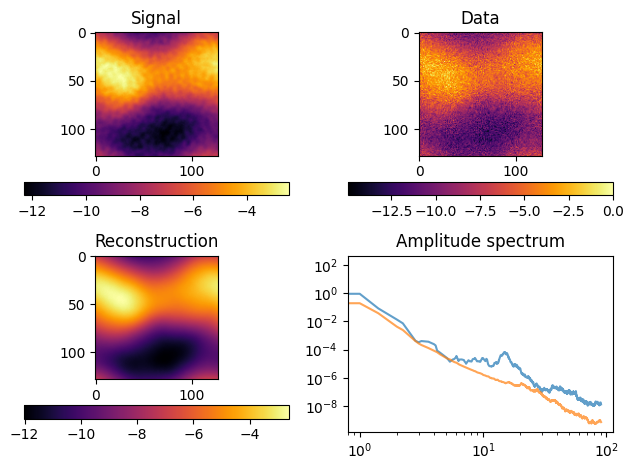

In [19]:
post_sr_mean = jft.mean(tuple(correlated_field(s) for s in samples))
post_ps_mean = jft.mean(tuple(cfm_ps(s) for s in samples)) 
grid = correlated_field.target_grids[0]
to_plot = [
    ("Signal", ground_truth, "im"),
    ("Data", noisy_data, "im"),
    ("Reconstruction", post_sr_mean, "im"),
    (
        "Amplitude spectrum",
        (
            grid.harmonic_grid.mode_lengths,
            fixed_pow_spec,
            post_ps_mean,
        ),
        "loglog",
    ),
]
fig, axs = plt.subplots(2, 2)
for ax, v in zip(axs.flat, to_plot):
    title, field, tp, *labels = v
    ax.set_title(title)
    if tp == "im":
        end = tuple(n * d for n, d in zip(grid.shape, grid.distances))
        im = ax.imshow(field, cmap="inferno")
        plt.colorbar(im, ax=ax, orientation="horizontal")
    else:
        ax_plot = ax.loglog if tp == "loglog" else ax.plot
        x = field[0]
        for f in field[1:]:
            ax_plot(x, f, alpha=0.7)
for ax in axs.flat[len(to_plot) :]:
    ax.set_axis_off()
fig.tight_layout()
fig.savefig("results_intro_full_reconstruction.png", dpi=400)
plt.show()